In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import time

import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize

In [2]:
# Set device dynamically
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data import

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# os.listdir()
# os.chdir('/drive/MyDrive/VIDEOS')

In [4]:
# Define the folder containing the videos
video_folder = "VIDEOS"  # Replace with your folder path
# video_folder = "/drive/MyDrive/VIDEOS"  # Replace with your folder path
output_dir = "/video_dataset"  # Output directory for processed files

# Video dimensions and frame count
video_dim = (128, 128)  # Width, Height
frame_count = 16  # Number of frames per video

# Function to process a single video
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    success, frame = cap.read()
    while success and len(frames) < frame_count:
        # Resize frame to 128x128
        frame_resized = cv2.resize(frame, video_dim, interpolation=cv2.INTER_AREA)
        frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        frames.append(frame_gray)
        success, frame = cap.read()
    cap.release()

    # Adjust the number of frames to exactly 16
    if len(frames) < frame_count:
        # Repeat the last frame to reach 16
        frames += [frames[-1]] * (frame_count - len(frames))
    elif len(frames) > frame_count:
        # Sample 16 frames evenly
        indices = np.linspace(0, len(frames) - 1, frame_count).astype(int)
        frames = [frames[i] for i in indices]
    
    return np.stack(frames, axis=-1)  # Return as (128, 128, 16)

# Load all videos
video_files = sorted([os.path.join(video_folder, f) for f in os.listdir(video_folder) if f.endswith('.mp4')])
if len(video_files) < 48:
    raise ValueError("Not enough videos. At least 48 required.")

# Process videos
videos = [process_video(video) for video in video_files]
videos = np.array(videos)  # Convert to numpy array

# Split into training and testing datasets
train_videos = videos[:40]
test_videos = videos[40:48]

# Save the datasets
# os.makedirs(output_dir, exist_ok=True)
# train_path = os.path.join(output_dir, "train_videos.npy")
# test_path = os.path.join(output_dir, "test_videos.npy")

# np.save(train_path, train_videos)
# np.save(test_path, test_videos)

# print(f"Training videos saved to: {train_path}")
# print(f"Test videos saved to: {test_path}")

In [5]:
print("Shape of train_videos:", train_videos.shape)
print("Shape of test_videos:", test_videos.shape)

Shape of train_videos: (40, 128, 128, 16)
Shape of test_videos: (8, 128, 128, 16)


# PCA

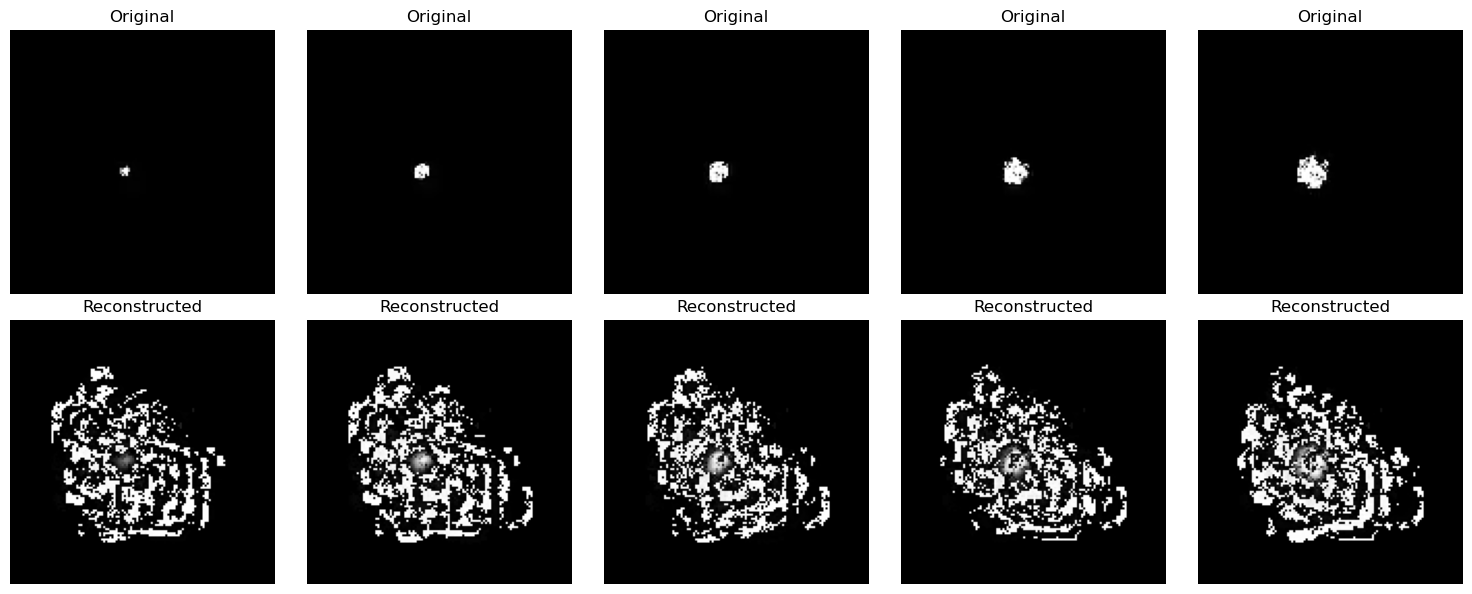

((640, 121), (640, 128, 128))

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load training dataset from previous step
# Each snapshot (image) is a sample, so we reshape the dataset accordingly
num_videos, height, width, timesteps = train_videos.shape
train_samples = train_videos.transpose(0, 3, 1, 2).reshape(-1, height * width)  # Flatten images

# Normalize the data (important for PCA)
train_samples_normalized = train_samples / 255.0

# Perform PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
compressed_data = pca.fit_transform(train_samples_normalized)  # Compressed representation
decompressed_data = pca.inverse_transform(compressed_data)  # Reconstruct data

# Reshape decompressed data back to image format
decompressed_images = (decompressed_data * 255).astype(np.uint8)
decompressed_images = decompressed_images.reshape(-1, height, width)

# Show original and reconstructed images for comparison
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axes[0, i].imshow(train_samples[i].reshape(height, width), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    axes[1, i].imshow(decompressed_images[i], cmap='gray')
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

compressed_data.shape, decompressed_images.shape    


In [7]:

# Reshape test videos to match PCA input requirements
num_test_videos, test_height, test_width, test_timesteps = test_videos.shape
test_samples = test_videos.transpose(0, 3, 1, 2).reshape(-1, test_height * test_width)  # Flatten images

# Normalize the test samples
test_samples_normalized = test_samples / 255.0

# Apply PCA to reduce dimensions
test_compressed_data = pca.transform(test_samples_normalized)

# Reconstruct the test dataset from the compressed representation
test_decompressed_data = pca.inverse_transform(test_compressed_data)

# Reshape reconstructed data back to image format
test_decompressed_images = (test_decompressed_data * 255).astype(np.uint8)
test_decompressed_images = test_decompressed_images.reshape(-1, test_height, test_width)

# Evaluate reconstruction quality on the test dataset
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Compute MSE and SSIM for test dataset
mse_test = mean_squared_error(test_samples.flatten(), test_decompressed_data.flatten())
ssim_test = np.mean([
    ssim(test_samples[i].reshape(test_height, test_width), test_decompressed_images[i],
         data_range=test_decompressed_images[i].max() - test_decompressed_images[i].min())
    for i in range(len(test_samples))
])

# Display test metrics
mse_test, ssim_test


(936.431270952228, 0.6316713702808143)

# Convolutional Auto Encoder

In [8]:
import tensorflow as tf
from keras import layers, models, metrics, callbacks
from keras.models import Model

latent_dim = 100  # Example latent dimension
input_shape = (height, width, 1)

cae_results = {}


# Encoder
encoder = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation='sigmoid', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(512, (3, 3), activation='sigmoid', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Flatten(),
    layers.Dense(latent_dim, activation='relu')
])

# Decoder
decoder = models.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(16 * 16 * 512, activation='sigmoid'),
    layers.Reshape((16, 16, 512)),
    layers.Conv2DTranspose(512, (3, 3), activation='sigmoid', padding='same'),
    layers.BatchNormalization(),
    layers.UpSampling2D((2, 2)),
    layers.Conv2DTranspose(256, (3, 3), activation='sigmoid', padding='same'),
    layers.BatchNormalization(),
    layers.UpSampling2D((2, 2)),
    layers.Conv2DTranspose(128, (3, 3), activation='sigmoid', padding='same'),
    layers.BatchNormalization(),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
])

# Autoencoder (CAE)
input_img = layers.Input(shape=input_shape)
encoded = encoder(input_img)
decoded = decoder(encoded)
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=[metrics.binary_accuracy])

In [9]:
# Normalize training data and test data to [0, 1] range and reshape for CAE
train_images = train_samples.reshape(-1, height, width, 1) / 255.0
test_images = test_samples.reshape(-1, height, width, 1) / 255.0  

In [10]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the CAE
history = autoencoder.fit(
    train_images, train_images,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_split=0.2
)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - binary_accuracy: 0.6494 - loss: 0.2995 - val_binary_accuracy: 0.9589 - val_loss: 0.0237
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - binary_accuracy: 0.7730 - loss: 0.2012 - val_binary_accuracy: 0.9585 - val_loss: 0.0221
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - binary_accuracy: 0.8100 - loss: 0.1604 - val_binary_accuracy: 0.9480 - val_loss: 0.0286
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - binary_accuracy: 0.8365 - loss: 0.1343 - val_binary_accuracy: 0.9595 - val_loss: 0.0192
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - binary_accuracy: 0.8711 - loss: 0.1003 - val_binary_accuracy: 0.9594 - val_loss: 0.0183
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 75s 5s/step - binary_accuracy: 0.8888 - loss: 0.0814 - val_binary_accuracy: 0.9594 - val_loss: 0.0182
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - binary_accuracy: 0.8991 - loss: 0.0714 - val_binary_accuracy: 0.9593 - val_loss: 0.0185
Epoch 8/50
16/16 ━━━

In [11]:
# Evaluate reconstruction performance
reconstructed_train = autoencoder.predict(train_images)
reconstructed_test = autoencoder.predict(test_images)

# Calculate metrics
train_mse = mean_squared_error(train_images.flatten(), reconstructed_train.flatten())
test_mse = mean_squared_error(test_images.flatten(), reconstructed_test.flatten())

train_ssim = np.mean([
    ssim(train_images[i].reshape(128, 128), reconstructed_train[i].reshape(128, 128), data_range=1.0)
    for i in range(train_images.shape[0])
])
test_ssim = np.mean([
    ssim(test_images[i].reshape(128, 128), reconstructed_test[i].reshape(128, 128), data_range=1.0)
    for i in range(test_images.shape[0])
])

# Store results
cae_results[latent_dim] = {
    "Train MSE": train_mse,
    "Test MSE": test_mse,
    "Train SSIM": train_ssim,
    "Test SSIM": test_ssim
}

# Display CAE results
cae_results_df = pd.DataFrame(cae_results).T
cae_results_df


20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


,Train MSE,Test MSE,Train SSIM,Test SSIM
100,0.003946,0.004726,0.509047,0.504447


In [12]:
# # Encode using CAE
# encoder = Model(encoder_input, latent)
encoded_train_cae = encoder.predict(train_images)
encoded_test_cae = encoder.predict(test_images)

# # Encode and decode the test dataset
# reconstructed_test_cae = cae.predict(test_images)

# # Reshape reconstructed data back to original format
# reconstructed_test_cae = (reconstructed_test_cae * 255).astype(np.uint8).reshape(-1, 128, 128)


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 497ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 486ms/step


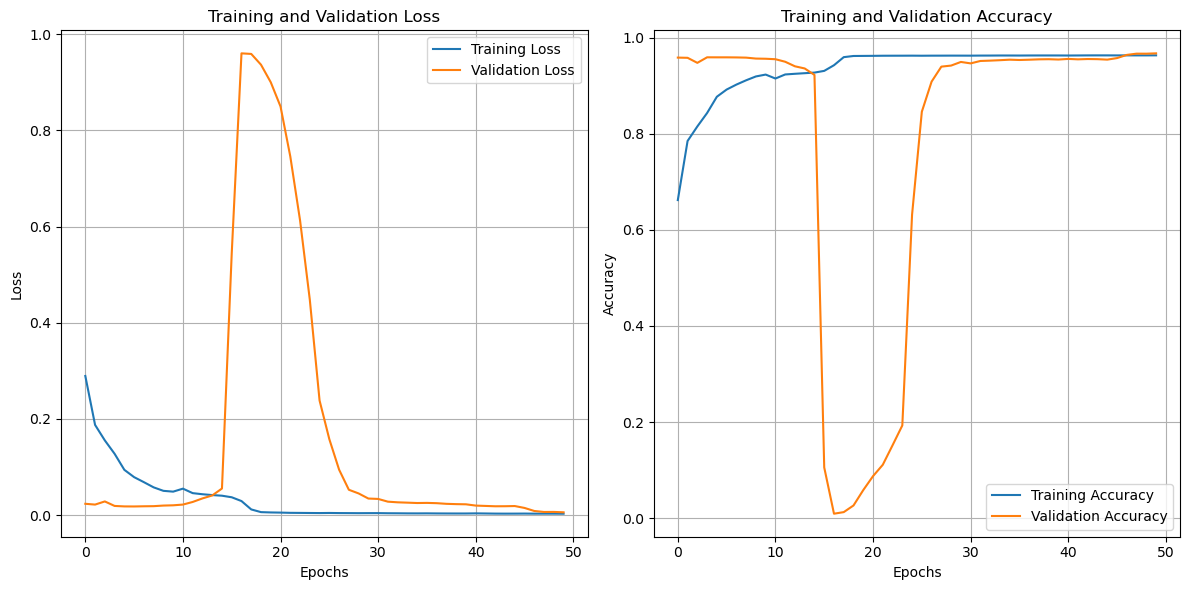

In [13]:
# Extract metrics from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Comparison of PCA & CAE

In [14]:
# Reconstruct images using CAE
# reconstructed_cae = cae.predict(train_images)

# Measure reconstruction error (MSE)
mse_cae_train = np.mean((train_images - reconstructed_train) ** 2)

# Compare with PCA
mse_pca_train = np.mean((train_samples_normalized - decompressed_data) ** 2)

print(f"MSE for PCA: {mse_pca_train}")
print(f"MSE for CAE: {mse_cae_train}")


MSE for PCA: 0.0007332143721270715
MSE for CAE: 0.003945865269066739


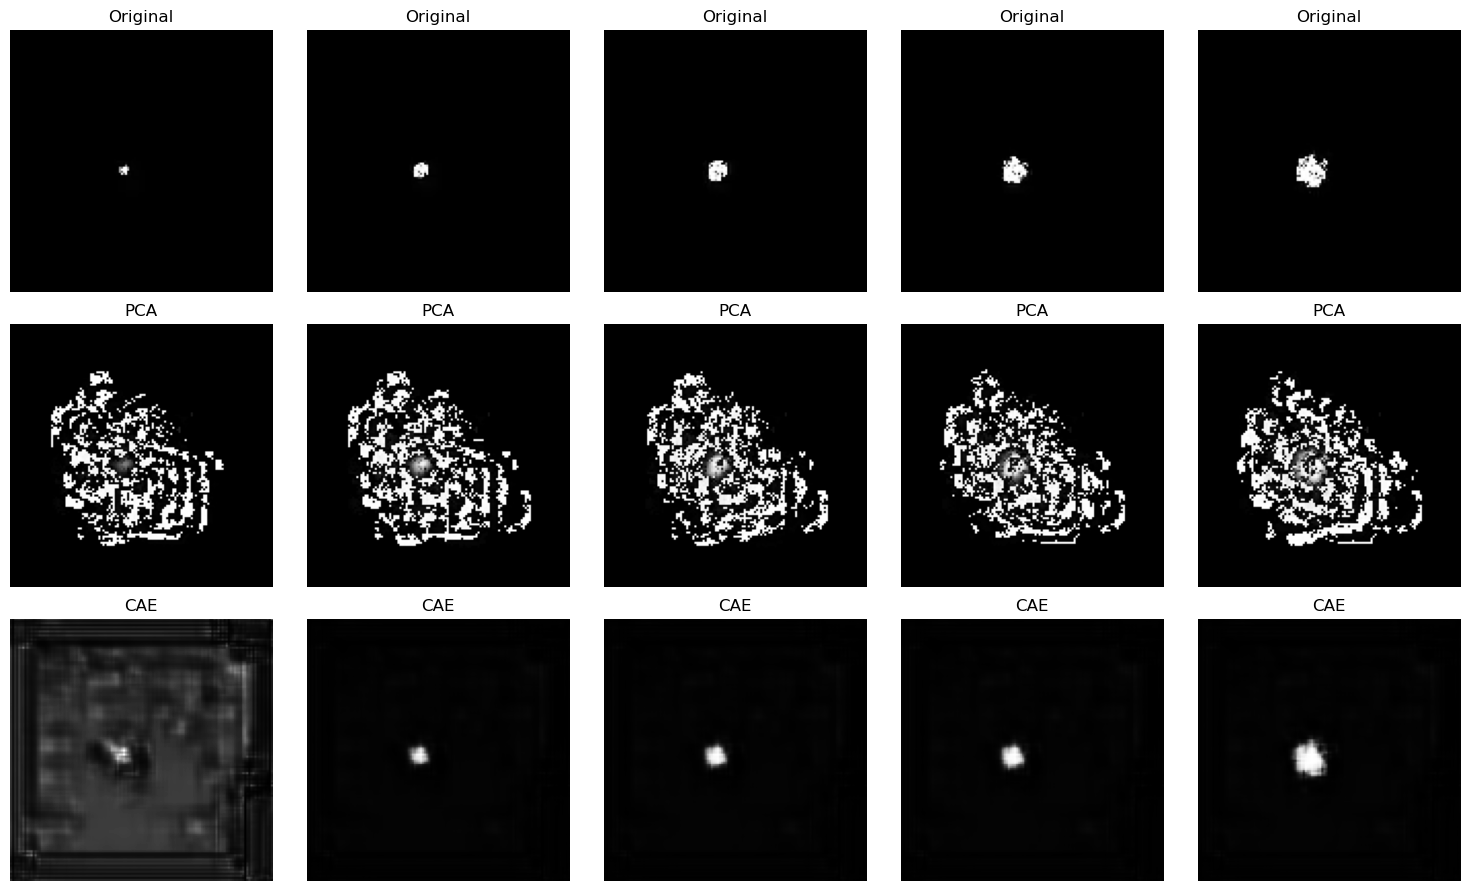

In [15]:
# Visualize original, PCA reconstructed, and CAE reconstructed images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for i in range(5):
    # Original
    axes[0, i].imshow(train_samples[i].reshape(height, width), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    # PCA Reconstruction
    axes[1, i].imshow(decompressed_images[i], cmap='gray')
    axes[1, i].set_title("PCA")
    axes[1, i].axis('off')

    # CAE Reconstruction
    axes[2, i].imshow(reconstructed_train[i].reshape(height, width), cmap='gray')
    axes[2, i].set_title("CAE")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()


In [16]:
# Compare with PCA
mse_pca_test = np.mean((test_samples_normalized - test_decompressed_data) ** 2)

# Evaluate CAE Reconstruction Quality
mse_cae_test = mean_squared_error(test_samples.flatten(), reconstructed_test.flatten())

# Compare with PCA results
print(f"MSE for PCA: {mse_pca_test}")
print(f"MSE for CAE: {mse_cae_test}")


MSE for PCA: 0.0020634252206552695
MSE for CAE: 937.1153564453125


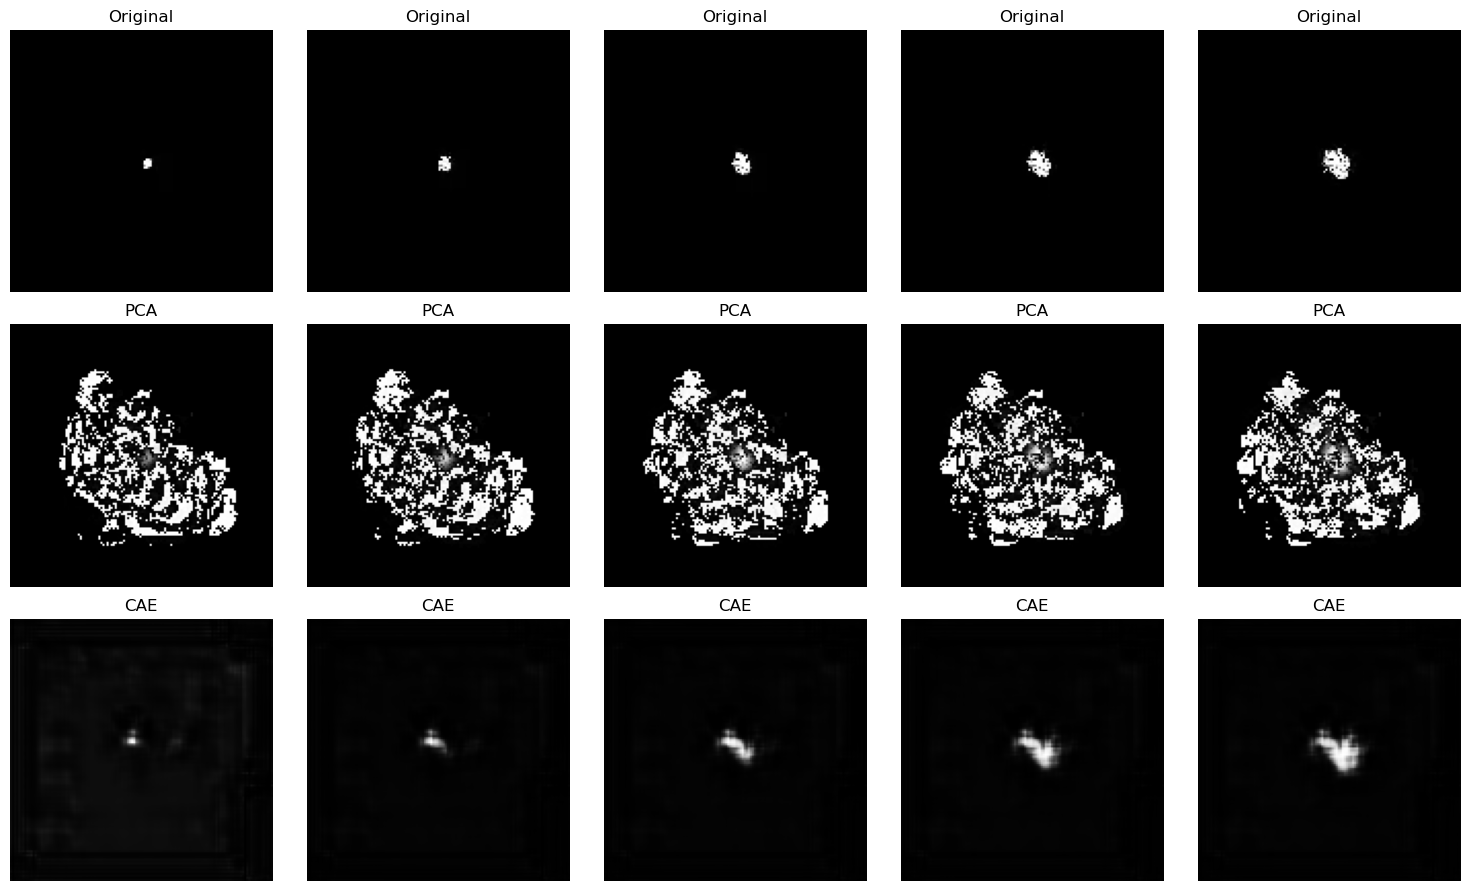

In [17]:
# Visualize PCA vs CAE Reconstructed Images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for i in range(5):
    # Original
    axes[0, i].imshow(test_samples[i].reshape(128, 128), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    # PCA Reconstruction
    axes[1, i].imshow(test_decompressed_images[i], cmap='gray')
    axes[1, i].set_title("PCA")
    axes[1, i].axis('off')

    # CAE Reconstruction
    axes[2, i].imshow(reconstructed_test[i], cmap='gray')
    axes[2, i].set_title("CAE")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()


# LSTM

In [18]:
import numpy as np

# Function to create overlapping sequences
def create_sequences(data, timesteps_in=4, timesteps_out=4):
    X, y = [], []
    for i in range(len(data) - timesteps_in - timesteps_out):
        X.append(data[i:i+timesteps_in])
        y.append(data[i+timesteps_in:i+timesteps_in+timesteps_out])
    return np.array(X), np.array(y)

# Create training and testing sequences
timesteps_in, timesteps_out = 4, 4
X_train, y_train = create_sequences(encoded_train_cae, timesteps_in, timesteps_out)
X_test, y_test = create_sequences(encoded_test_cae, timesteps_in, timesteps_out)


In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Define the LSTM model
latent_dim = X_train.shape[2]  # Latent space dimensionality from CAE encoder

# LSTM Input and Output
lstm_input = Input(shape=(timesteps_in, latent_dim))
lstm_output = LSTM(128, return_sequences=True)(lstm_input)
lstm_output = Dense(latent_dim, activation='linear')(lstm_output)

# Create and compile the model
lstm_model = Model(inputs=lstm_input, outputs=lstm_output)
lstm_model.compile(optimizer='adam', loss='mse')

# Summary of the LSTM model
lstm_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 4, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 4, 128)         │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4, 100)         │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,148 (508.39 KB)

 Trainable params: 130,148 (508.39 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the LSTM model
history = lstm_model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2596.2144 - val_loss: 2085.8347
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2691.3562 - val_loss: 2073.2449
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2742.9087 - val_loss: 2056.2285
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2624.5347 - val_loss: 2031.3961
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2602.0940 - val_loss: 2000.2172
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2540.1182 - val_loss: 1968.6761
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2556.0610 - val_loss: 1938.8492
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2521.2563 - val_loss: 1909.8325
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2468.3074 - val_loss: 1881.6215
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2457.3547 - val_loss: 1855.7662
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2294.2195 - val_l

In [21]:
# Predict latent sequences using the trained LSTM model
latent_predictions = lstm_model.predict(X_test)

# Decode latent predictions back into full space using CAE decoder
decoded_predictions = []
for i in range(latent_predictions.shape[0]):
    decoded_predictions.append(decoder.predict(latent_predictions[i]))
decoded_predictions = np.array(decoded_predictions)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━

In [22]:


# Reshape y_test to match the shape of decoded predictions for evaluation
decoded_ground_truth = []
for i in range(y_test.shape[0]):
    decoded_ground_truth.append(decoder.predict(y_test[i]))
decoded_ground_truth = np.array(decoded_ground_truth)

# Calculate evaluation metrics
mse = mean_squared_error(decoded_ground_truth.flatten(), decoded_predictions.flatten())
rmse = np.sqrt(mse)

# Calculate SSIM for each prediction
ssim_values = []
for i in range(decoded_ground_truth.shape[0]):
    for j in range(decoded_ground_truth.shape[1]):  # Per frame
        ssim_values.append(
            ssim(
                decoded_ground_truth[i, j].reshape(128, 128), 
                decoded_predictions[i, j].reshape(128, 128), 
                data_range=1.0
            )
        )
average_ssim = np.mean(ssim_values)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"Average SSIM: {average_ssim}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━

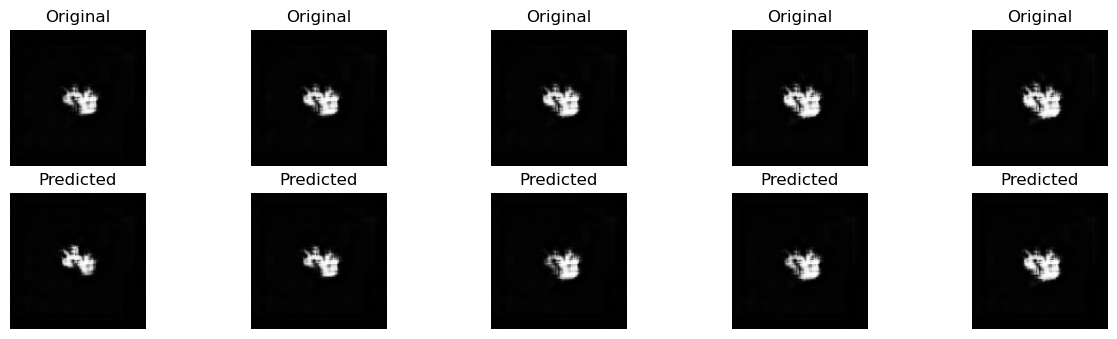

In [23]:
# Visualize original vs predicted sequences
n = 5  # Number of sequences to visualize
plt.figure(figsize=(15, 6))
for i in range(n):
    # Original sequence
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(decoded_ground_truth[i, -1].reshape(128, 128), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Predicted sequence
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_predictions[i, -1].reshape(128, 128), cmap="gray")
    plt.title("Predicted")
    plt.axis("off")
plt.show()


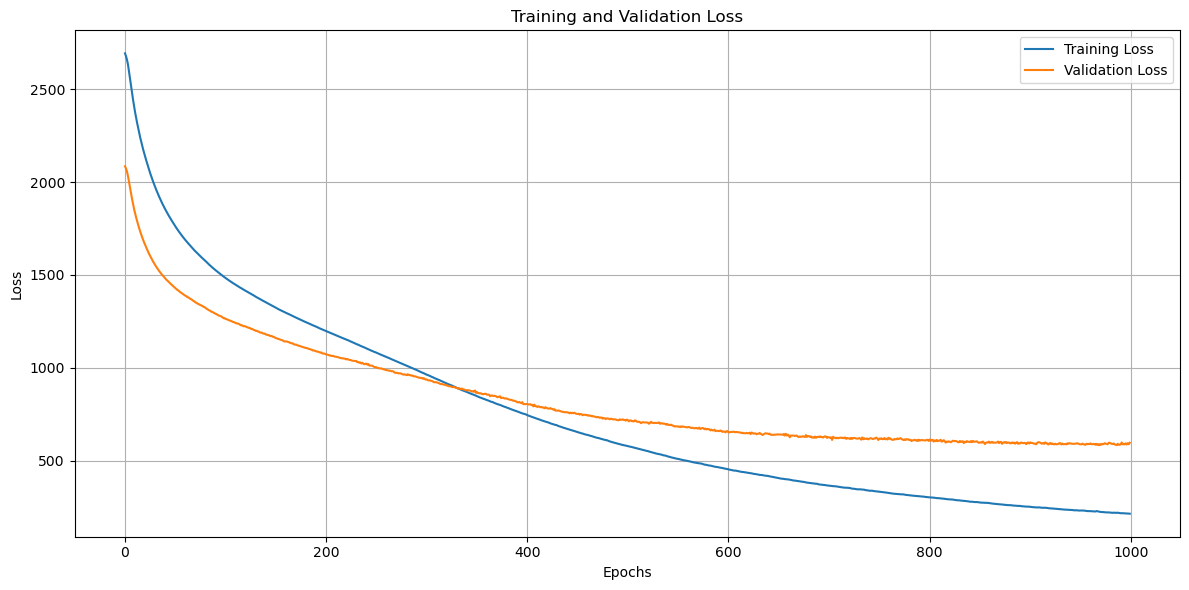

In [24]:
# Extract metrics from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
# train_accuracy = history.history['binary_accuracy']
# val_accuracy = history.history['val_binary_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training and validation accuracy
# plt.subplot(1, 2, 2)
# plt.plot(train_accuracy, label='Training Accuracy')
# plt.plot(val_accuracy, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)

plt.tight_layout()
plt.show()

# ConvLSTM

In [ ]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.bias = bias

        self.conv = nn.Conv2d(
            in_channels=input_dim + hidden_dim,
            out_channels=4 * hidden_dim,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias,
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)

        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (
            torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
            torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
        )

In [ ]:
class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, batch_first=True):
        super(ConvLSTM, self).__init__()
        self.num_layers = num_layers
        self.batch_first = batch_first

        self.layers = nn.ModuleList([
            ConvLSTMCell(input_dim if i == 0 else hidden_dim, hidden_dim, kernel_size)
            for i in range(num_layers)
        ])

    def forward(self, input_tensor, hidden_state=None):
        if not hidden_state:
            hidden_state = self._init_hidden(input_tensor)

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        output_seq = []
        for layer_idx, cell in enumerate(self.layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = cell(cur_layer_input[:, t, :, :, :], (h, c))
                output_inner.append(h)
            cur_layer_input = torch.stack(output_inner, dim=1)
            output_seq.append(cur_layer_input)

        return output_seq[-1]

    def _init_hidden(self, input_tensor):
        batch_size, seq_len, channels, height, width = input_tensor.size()
        hidden_state = [
            layer.init_hidden(batch_size, (height, width)) for layer in self.layers
        ]
        return hidden_state

In [ ]:
# Dummy data for demonstration
input_dim = 1  # Grayscale frames
hidden_dim = 64
kernel_size = 3
num_layers = 2
num_epochs = 20
batch_size = 32
train_losses = []
val_losses = []
sequence_length = 4
height, width = 128, 128

# Convert video sequences to tensors
train_tensor = torch.tensor(train_videos).float().unsqueeze(2)  # Add channel dimension
test_tensor = torch.tensor(test_videos).float().unsqueeze(2)

# Define the model
conv_lstm = ConvLSTM(input_dim, hidden_dim, kernel_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(conv_lstm.parameters(), lr=0.001)


In [ ]:
# Split train/validation (assuming 80% train, 20% validation)
val_split = int(0.8 * train_tensor.size(0))
train_data, val_data = train_tensor[:val_split], train_tensor[val_split:]

for epoch in range(num_epochs):
    conv_lstm.train()
    epoch_train_loss = 0
    
    # Training Phase
    for i in range(0, train_data.size(0), batch_size):
        inputs = train_data[i:i+batch_size]
        targets = inputs.clone()
        
        # Forward pass
        outputs = conv_lstm(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    train_losses.append(epoch_train_loss / (train_data.size(0) // batch_size))
    
    # Validation Phase
    conv_lstm.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for i in range(0, val_data.size(0), batch_size):
            inputs = val_data[i:i+batch_size]
            targets = inputs.clone()
            outputs = conv_lstm(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item()
    
    val_losses.append(epoch_val_loss / (val_data.size(0) // batch_size))
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")



In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from skimage.metrics import structural_similarity as ssim

# Predict with ConvLSTM
conv_lstm.eval()
with torch.no_grad():
    predicted_test = conv_lstm(test_tensor.cuda())

# Decode CAE+LSTM predictions and compare metrics
mse_clstm = mean_squared_error(test_tensor.cpu().numpy(), predicted_test.cpu().numpy())
rmse_clstm = np.sqrt(mse_clstm)
ssim_clstm = np.mean([
    ssim(test_tensor[i, 0].cpu().numpy(), predicted_test[i, 0].cpu().numpy())
    for i in range(len(test_tensor))
])

print(f"ConvLSTM - MSE: {mse_clstm}, RMSE: {rmse_clstm}, SSIM: {ssim_clstm}")


# Conclusion

PCA is not suitable for complex, sparse, and non-linear data here. PCA introduces significant noise in the reconstructions.

CAE performs much better than PCA in terms of retaining the sparse structure of the white regions. 
The reason is that CAE outperforms PCA by learning non-linear features, leading to improved reconstruction accuracy for sparse and non-linear patterns. It better preserves the structure of the white regions while introducing slight blurriness. These blurriness may indicate underfitting or a limitation in capturing very fine details. With the augmentation of latent space dimension, CAE may perform better and the blurriness might be reduced in this way.

The LSTM successfully predicts sequences in the reduced latent space. LSTM predictions capture the general patterns of the white regions but also exhibit some blurriness. 
That is because it captures temporal dependencies, making it suitable for spatiotemporal modeling.

For the structure ConvLTSM, due to the limit of computer performance, the running of this algorithm has not accomplished. 